# Compressive sensing example


In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Load example image

In [57]:
def crop_center(img,cropx,cropy):
    #y,x = img.shape
    y = img.shape[-2]
    x = img.shape[-1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    if len(img.shape) == 2:
        return img[starty:starty+cropy,startx:startx+cropx]
    if len(img.shape) == 3:
        return img[0,starty:starty+cropy,startx:startx+cropx]

path = './test_data/'
img_name = "poster"
#img_name = "F16_GT"
#img_name = "sf4_rgb"
#img_name  = 'library'
img_path = path + img_name + ".png"

img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

img_np_small = np.array([crop_center(img_np[0],128,128)])
img_var = np_to_var(img_np_small).type(dtype)
output_depth = img_np.shape[0]

## Define forward model

In [30]:
X = img_var.view(-1, np.prod(img_var.shape) )
n = X.shape[1]
m = int(n/3)
A = torch.empty(n,m).uniform_(-1, 1).type(dtype)
A *= 1/np.sqrt(m)

def forwardm(img_var):
    X = img_var.view(-1 , np.prod(img_var.shape) ) 
    return torch.mm(X,A)

measurement = forwardm(img_var)

5461


## DD reconstruction and helper functions

In [31]:
def get_net_input(num_channels,w=128,h=128):
    totalupsample = 2**len(num_channels)
    width = int(128/totalupsample)
    height = int(128/totalupsample)
    shape = [1,num_channels[0], width, height]
    net_input = Variable(torch.zeros(shape)).type(dtype)
    net_input.data.uniform_()
    net_input.data *= 1./10
    return net_input

def get_random_img(num_channels,ni=None):
    if ni is None:
        ni = get_net_input(num_channels)
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    print("generated random image with", num_channels, " network has ", num_param(net) )
    return net(ni)

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='gray')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    plt.axis('off')    
    
def plot_img(img_ref): 
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure   
    ax1 = fig.add_subplot(231)
    ax1.imshow(img_ref,cmap='gray')
    #ax1.set_title('Original image')
    ax1.axis('off')
    
def init_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            #m.weight.data.uniform_()
            #torch.nn.init.xavier_uniform(m.weight)
            #nn.init.uniform_(m.weight)
            torch.nn.init.normal_(m.weight)

def snr(x_hat,x_true):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse= np.sum( np.square(x_hat-x_true) )
    #snr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    snr_ = mse / np.sum( np.square(x_true) )
    return snr_

In [32]:
def dd_recovery(measurement,img_var,num_channnels,num_iter=6000,apply_f=forwardm,ni=None):
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    #net.apply(init_weights)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                                net_input=ni,
                        reg_noise_std=0.0,num_iter=num_iter,LR = 0.005,
                        img_noisy_var=measurement.type(dtype),
                        net=net,apply_f = apply_f,img_clean_var=img_var.type(dtype),
                        upsample_mode='bilinear',
                        )
    print(num_param(net))
    out_img_var = net( ni.type(dtype) )
    return out_img_var

## Example reconstruction

This demonstrates that reconstruction with a deep decoder works well, but a deconvolutional decoder does not enable good reconstructions.

In [33]:
k=22
num_channels = [k]*4
measurement = forwardm(img_var).type(dtype)
out_img_var = dd_recovery(measurement,img_var,num_channels)

input shape:  [1, 22, 8, 8]
optimize with adam 0.005
2662ation 05990    Train loss 0.000473  Actual loss 0.000794 Actual loss orig 0.000794 


In [ ]:
def dconv_recovery(img_var):
    measurement = forwardm(img_var).type(dtype)
    num_channels = [6]*6
    net = deconv_decoder(1,num_channels_up=num_channels,filter_size=4,stride=2,padding=1).type(dtype)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,num_iter=5000,LR = 0.0025,
                        img_noisy_var=measurement,
                        net=net,apply_f = forwardm,img_clean_var=img_var.type(dtype),
                        upsample_mode='deconv' )
    print(num_param(net))
    out_img_var = net( ni.type(dtype) )
    return out_img_var

out_img_dc_var = dconv_recovery(img_var)

input shape:  [1, 6, 4, 4]
optimize with adam 0.0025
2946ation 04990    Train loss 0.000927  Actual loss 0.007248 Actual loss orig 0.007248 


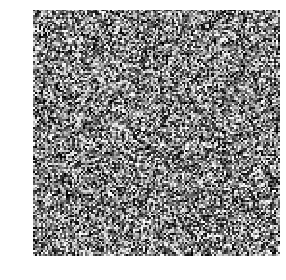

In [60]:
plot_img(img_var.data.cpu().numpy()[0,0])
#plot_img(out_img_var.data.cpu().numpy()[0,0])
#plot_img(out_img_dc_var.data.cpu().numpy()[0,0])

def savefig(filename,img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')
    
savefig(img_name + "_orig.png',img_var.data.cpu().numpy()[0,0])

# Compressive sensing on random images

Our main result shows that taking random linear measurements on the order of the number of parameters of the deep decoder is suffient for recovery is possible. In order to see whether that is also necessary and thus the number of parameters captures the complexity of the range space of the deep decoder, we conduct the following experiment to recover an image in the range of the deep decoder.

In order to generate an image, we can in principle simply choose the coefficients of the deep decoder at random. However, for a deep decoder with a fixed number of parameters, this tends to generate simple images, in that often a deep decoder with much fewer coefficients can represent it well. To ensure that we generate a sufficiently complex image, we generate an image in the range of the generator by finding the best representation of noise with the deep decoder. 

In [59]:
numpoints = 8
ms = [ int(100*np.exp(5.5/numpoints*i)) for i in range(numpoints) ] #[100,200,,17000]
print(ms)
ks = [10,20,30,50,150,250]
err = np.zeros((len(ms), len(ks)))

numit = 10

for q in range(numit):
    for j,m in enumerate(ms):
        for ell,k in enumerate(ks):
            # generate input
            num_channels = [k]*4
            ni = get_net_input(num_channels)
        
            # get random noise, and find approximation to it in the range of the generator
            img_var.data.uniform_()
            img_approx = Variable(dd_recovery(img_var,img_var,num_channels,ni=ni,apply_f=None,num_iter=3000))

            print("number useful variables / number observations", (k**2*4 + k) /m)
            print("number observations / number of variables", m/n)
            print("m,n,nump",m,n,k**2*4 + k)
            
            # generate random matrix
            A = 10*torch.empty(n,m).normal_(0, 1/np.sqrt(m)).type(dtype)
            
            def forwardm(img):
                X = img.view(-1 , np.prod(img.shape) )
                return torch.mm(X,A)

            measurement = forwardm(img_approx).type(dtype)
            out_img_var = dd_recovery(measurement,img_approx,num_channels,ni=ni,apply_f=forwardm,num_iter=10000)
    
            #plot_img(img_approx.data.cpu().numpy()[0,0])
            #plot_img(out_img_var.data.cpu().numpy()[0,0])
    
            error = snr(out_img_var.data.cpu().numpy()[0] , img_approx.data.cpu().numpy()[0])
            print("error: ", error, "\n")
            err[j,ell] += error/numit

input provided
optimize with adam 0.005


KeyboardInterrupt: 

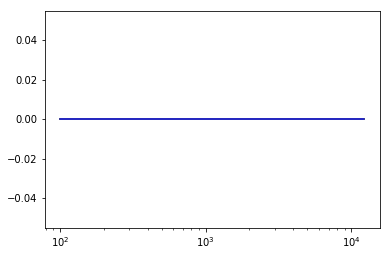

In [62]:
# plot and save
plt.xscale('log')
for i,c in enumerate(['b','r','g','y','b']):
    plt.plot(ms,err[:,i],c)
plt.show()

np.savetxt("csrandimg_"+img_name+".csv", np.vstack([ np.array(ms) ,np.array(err).T]).T , delimiter="\t")

## Compressive sensing on a natural image for varying number of parameters and number of measurements

In [43]:
# get a small image
img_name = "poster" # "F16_GT"
img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_np_small = np.array([crop_center(img_np[0],128,128)])
img_var = np_to_var(img_np_small).type(dtype)

numpoints = 8
ms = [ int(100*np.exp(5.5/numpoints*i)) for i in range(numpoints) ] #[100,200,,17000]
ks = [10,20,30,50,150,250]

err2 = np.zeros((len(ms), len(ks)))

numit = 10

for q in range(numit):
    for j,m in enumerate(ms):
        for ell,k in enumerate(ks):
        
            # generate fixed input
            num_channels = [k]*4
            ni = get_net_input(num_channels)
        
            #print("number useful variables / number observations", num_param(net)/m)
            print("number useful variables / number observations", (k**2*4 + k) /m)
            print("number observations / number of variables", m/n)
            print("m,n,nump",m,n,k**2*4 + k)

            A = 10*torch.empty(n,m).normal_(0, 1/np.sqrt(m)).type(dtype)
            
            def forwardm(img):
                X = img.view(-1 , np.prod(img.shape) )
                return torch.mm(X,A)
            
            # take measurement of original image
            measurement = forwardm(img_var).type(dtype)
            out_img_var = dd_recovery(measurement,img_var,num_channels,ni=ni,apply_f=forwardm,num_iter=6000)
        
            error = snr(out_img_var.data.cpu().numpy()[0] , img_var.data.cpu().numpy()[0])
            print("error: ", error, "\n")
            err2[j,ell] += error/numit

number useful variables / number observations 4.1
number observations / number of variables 0.006103515625
m,n,nump 100 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 0.000000  Actual loss 0.054498 Actual loss orig 0.054498    
error:  0.6411835 

number useful variables / number observations 16.2
number observations / number of variables 0.006103515625
m,n,nump 100 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.000000  Actual loss 0.033326 Actual loss orig 0.033326    
error:  0.3920929 

number useful variables / number observations 36.3
number observations / number of variables 0.006103515625
m,n,nump 100 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.003548  Actual loss 0.035698 Actual loss orig 0.035698    
error:  0.41986442 

number useful variables / number observations 100.5
number observations / number of variables 0.006103515625
m,n,nump 100 16384 10050
input provided
opt

13050tion 05990    Train loss 0.001594  Actual loss 0.001475 Actual loss orig 0.001475   
error:  0.017505378 

number useful variables / number observations 57.64066496163683
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.000006  Actual loss 0.001183 Actual loss orig 0.001183   
error:  0.013918822 

number useful variables / number observations 160.00639386189258
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.000003  Actual loss 0.000838 Actual loss orig 0.000838   
error:  0.009861791 

number useful variables / number observations 0.13183279742765272
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 1.141827  Actual loss 0.003731 Actual loss orig 0.003731  
error:  0.0

2220ation 05990    Train loss 0.005683  Actual loss 0.031882 Actual loss orig 0.031882    
error:  0.37517112 

number useful variables / number observations 18.333333333333332
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.029595  Actual loss 0.032950 Actual loss orig 0.032950    
error:  0.38877645 

number useful variables / number observations 50.75757575757576
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.000000  Actual loss 0.020558 Actual loss orig 0.020558    
error:  0.2418691 

number useful variables / number observations 455.3030303030303
number observations / number of variables 0.0120849609375
m,n,nump 198 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.000774  Actual loss 0.032278 Actual loss orig 0.032278  3 
error:  0.379

input provided
optimize with adam 0.005


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13050tion 05990    Train loss 0.001616  Actual loss 0.001449 Actual loss orig 0.001449 
error:  0.017005272 

number useful variables / number observations 57.64066496163683
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.001779  Actual loss 0.001084 Actual loss orig 0.001084   
error:  0.0127444705 

number useful variables / number observations 160.00639386189258
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.116646  Actual loss 0.000813 Actual loss orig 0.000813   
error:  0.008993751 

number useful variables / number observations 0.13183279742765272
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 0.993266  Actual loss 0.003244 Actual loss orig 0.003244  
error:  0.03

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2220ation 05990    Train loss 0.202846  Actual loss 0.001192 Actual loss orig 0.001192 
error:  0.015404466 

number useful variables / number observations 1.167202572347267
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.227491  Actual loss 0.000952 Actual loss orig 0.000952  
error:  0.008411814 

number useful variables / number observations 3.2315112540192925
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.013586  Actual loss 0.000568 Actual loss orig 0.000568  
error:  0.0070038205 

number useful variables / number observations 28.987138263665596
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.011097  Actual loss 0.000321 Actual loss orig 0.000321  
error:  0.003

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



114150ion 05990    Train loss 0.007226  Actual loss 0.000367 Actual loss orig 0.000367 
error:  0.0042342395 

number useful variables / number observations 80.46623794212219
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.002062  Actual loss 0.000350 Actual loss orig 0.000350  
error:  0.004093266 

number useful variables / number observations 0.0662786938247656
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 0.594539  Actual loss 0.002839 Actual loss orig 0.002839  
error:  0.0346259 

number useful variables / number observations 0.2618816682832202
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.074455  Actual loss 0.000513 Actual loss orig 0.000513  
error:  0.005777

315250ion 05990    Train loss 0.000024  Actual loss 0.007619 Actual loss orig 0.007619   
error:  0.089692555 

number useful variables / number observations 0.5216284987277354
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 3.144005  Actual loss 0.015468 Actual loss orig 0.015468   
error:  0.18170722 

number useful variables / number observations 2.0610687022900764
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.048589  Actual loss 0.006217 Actual loss orig 0.006217   
error:  0.07385596 

number useful variables / number observations 4.6183206106870225
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.001155  Actual loss 0.004393 Actual loss orig 0.004393   
error:  0.051712

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4830ation 05990    Train loss 0.015608  Actual loss 0.005137 Actual loss orig 0.005137 
error:  0.06021849 

number useful variables / number observations 12.786259541984732
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.000000  Actual loss 0.003665 Actual loss orig 0.003665   
error:  0.043115254 

number useful variables / number observations 114.69465648854961
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.000132  Actual loss 0.002561 Actual loss orig 0.002561   
error:  0.030128963 

number useful variables / number observations 318.38422391857506
number observations / number of variables 0.0479736328125
m,n,nump 786 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.000096  Actual loss 0.002248 Actual loss orig 0.002248   
error:  0.02

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



114150ion 05990    Train loss 0.000666  Actual loss 0.000889 Actual loss orig 0.000889 
error:  0.010821622 

number useful variables / number observations 160.00639386189258
number observations / number of variables 0.095458984375
m,n,nump 1564 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.006256  Actual loss 0.000871 Actual loss orig 0.000871   
error:  0.010538536 

number useful variables / number observations 0.13183279742765272
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 410
input provided
optimize with adam 0.005
610ration 05990    Train loss 2.025880  Actual loss 0.006626 Actual loss orig 0.006626  
error:  0.07790779 

number useful variables / number observations 0.5209003215434084
number observations / number of variables 0.1898193359375
m,n,nump 3110 16384 1620
input provided
optimize with adam 0.005
2220ation 05990    Train loss 0.144795  Actual loss 0.000908 Actual loss orig 0.000908  
error:  0.0104

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2220ation 05990    Train loss 0.103118  Actual loss 0.000667 Actual loss orig 0.000667 
error:  0.0072002118 

number useful variables / number observations 0.5868089233753637
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 3630
input provided
optimize with adam 0.005
4830ation 05990    Train loss 0.083360  Actual loss 0.000559 Actual loss orig 0.000559  
error:  0.0051842355 

number useful variables / number observations 1.6246362754607178
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.028692  Actual loss 0.000260 Actual loss orig 0.000260  
error:  0.0026105214 

number useful variables / number observations 14.573229873908826
number observations / number of variables 0.3775634765625
m,n,nump 6186 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.034056  Actual loss 0.000252 Actual loss orig 0.000252  
error:  0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4830ation 05990    Train loss 0.029336  Actual loss 0.000326 Actual loss orig 0.000326 
error:  0.0034641582 

number useful variables / number observations 0.8168739331870275
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 10050
input provided
optimize with adam 0.005
13050tion 05990    Train loss 0.012945  Actual loss 0.000183 Actual loss orig 0.000183  
error:  0.002170161 

number useful variables / number observations 7.327481102170203
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 90150
input provided
optimize with adam 0.005
114150ion 05990    Train loss 0.006862  Actual loss 0.000090 Actual loss orig 0.000090  
error:  0.0009669987 

number useful variables / number observations 20.340567341298872
number observations / number of variables 0.75091552734375
m,n,nump 12303 16384 250250
input provided
optimize with adam 0.005
315250ion 05990    Train loss 0.012107  Actual loss 0.000138 Actual loss orig 0.000138  
erro

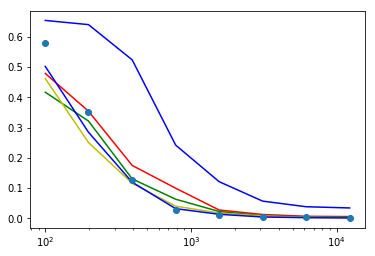

In [44]:
# plot and save
plt.xscale('log')
for i,c in enumerate(['b','r','g','y','b','o']):
    plt.plot(ms,err2[:,i],c)
plt.show()

np.savetxt("csf16img_"+img_name+".csv", np.vstack([ np.array(ms) ,np.array(err2).T]).T , delimiter="\t")